# Co-Authorship

In [1]:
import networkx as nx
import pickle as pk
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
allPapers = pk.loads(open(addressBook["serializedData"]+"allPapers.dic", "rb").read())
annualPapers = pk.loads(open(addressBook["serializedData"]+"annualPapers.dic", "rb").read())

First, we want to show the static network

Making the dictionary of edges. Each key denotes an edge and the corrosponding value, shows the weight of that edge

In [4]:
coauthorshipDict = {}
nodes = set()
for doi, paper in allPapers.items():
    authors = [auth.strip() for auth in paper["AU"].split(";")]
    if len(authors) == 0:
        continue
    elif len(authors) == 1:
        nodes.add(authors[0])
        if (authors[0],authors[0]) in coauthorshipDict.keys():
            coauthorshipDict[(authors[0],authors[0])] += 1
        else:
            coauthorshipDict[(authors[0], authors[0])] = 1
    else:
        authors = list(combinations(authors,2))
        for state in authors:
            nodes.add(state[0])
            nodes.add(state[1])
            reversedState = state[::-1]
            if state in coauthorshipDict.keys():
                coauthorshipDict[state] += 1
            elif reversedState in coauthorshipDict.keys():
                coauthorshipDict[reversedState] += 1
            else:
                coauthorshipDict[state] = 1

Creating 3-tuples of the edge dictionary becasue networkx needs 3-tuple to build a weighted network

In [5]:
threeTupleDic = []
for edge, weight in coauthorshipDict.items():
    threeTupleDic.append((edge[0],edge[1],weight))

Then, we creat the network

In [6]:
G1 = nx.Graph()
G1.add_nodes_from(nodes)
G1.add_weighted_edges_from(threeTupleDic,weight="weight")
nx.readwrite.write_gexf(G1,"./coauthorshipNetwork.gexf")
nx.readwrite.write_gml(G1,"./coauthorshipNetwork.gml")

Now, we want to build the dynamic graph

In [7]:
d=0
dynamicCoautorship = {}
yearlyNodes = {}
for year, papers in annualPapers.items():
    yearlyNodes[year] = set()
    dynamicCoautorship[year] = {}
    for doi, paper in papers.items():
        authors = [auth.strip() for auth in paper["AU"].split(";")]
        if len(authors) == 0:
            continue
        elif len(authors) == 1:
            d+=1
            yearlyNodes[year].add(authors[0])
#             if (authors[0], authors[0]) in dynamicCoautorship[year].keys():
#                 dynamicCoautorship[year][(authors[0], authors[0])] += 1
#             else:
#                 dynamicCoautorship[year][(authors[0], authors[0])] = 1
        else:
            authors = list(combinations(authors, 2))
            for state in authors:
                yearlyNodes[year].add(state[0])
                yearlyNodes[year].add(state[1])
                reversedState = state[::-1]
                if state in dynamicCoautorship[year].keys():
                    dynamicCoautorship[year][state] += 1
                elif reversedState in dynamicCoautorship[year].keys():
                    dynamicCoautorship[year][reversedState] += 1
                else:
                    dynamicCoautorship[year][state] = 1

In [8]:
dynamicThreeTupleDic = {}
for year, papers in dynamicCoautorship.items():
    dynamicThreeTupleDic[year] = []
    for edge, weight in papers.items():
        dynamicThreeTupleDic[year].append((edge[0], edge[1], weight))

In [9]:
graphs = {}
for index,year in enumerate(dynamicThreeTupleDic):
    G = nx.Graph()
    G.add_nodes_from(yearlyNodes[year])
    G.add_weighted_edges_from(dynamicThreeTupleDic[year], weight="weight")
    graphs[year] = G
    nx.readwrite.write_gexf(G,f'./Coauthorship Network/{index}.gexf')

In [10]:
for k,r in enumerate(dynamicThreeTupleDic):
    handle = open(f'./Coauthorship Network/{r}.gexf',"w", newline='\n')
    for w, v in enumerate(open(f'./Coauthorship Network/{k}.gexf').readlines()):
        if w==2:
            handle.write("<graph mode=\"slice\" defaultedgetype=\"directed\" timerepresentation=\"timestamp\" timestamp=\"" + str(r) +"\">\n")
        else:
            handle.write(v)
    handle.close()

Now, we want to calculate the graph density during the time

In [11]:
yearlyNodesCount = {year:len(yearlyNodes[year]) for year in yearlyNodes}

In [12]:
graphDensity = {}
for year in graphs:
    graphDensity[year] = nx.density(graphs[year])

In [13]:
df = pd.DataFrame({"Year":[int(y) for y in graphDensity.keys()],"Coauthorship Density":[v for v in graphDensity.values()]})

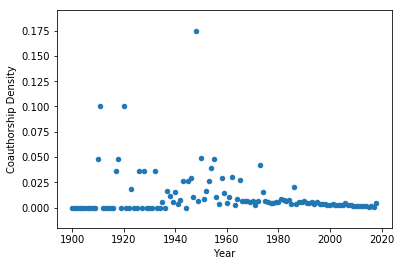

In [14]:
df.plot(kind="scatter", x="Year", y="Coauthorship Density")
plt.savefig("Coauthorship_Density.png")
plt.show()

Now, we want to see the densification through the time

In [15]:
densification = {}
for year, graph in graphs.items():
    densification[year] = graph.number_of_edges()/graph.number_of_nodes()

In [16]:
densificationDF = pd.DataFrame.from_dict(densification, orient="index").reset_index().rename(columns={"index":"Year",0:"Densification"})
for col in densificationDF:
    densificationDF[col] = pd.to_numeric(densificationDF[col])

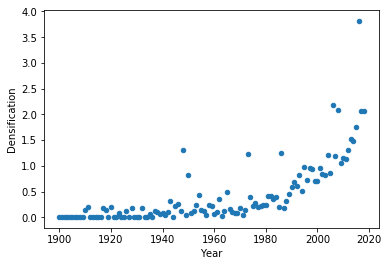

In [17]:
densificationDF.plot(kind="scatter",x="Year", y="Densification")
plt.savefig("densification.eps", foemat="eps", dpi=1000)
plt.show()

Now, we want to see the evolution of path length in co-authorship network

In [15]:
dynamicCoautorshipGraph = {}
for year in dynamicThreeTupleDic:
    G=nx.Graph()
    G.add_nodes_from(yearlyNodes[year])
    G.add_weighted_edges_from(dynamicThreeTupleDic[year])
    dynamicCoautorshipGraph[year] = G

In [16]:
dynamicGiantComponent = {}
for year in dynamicCoautorshipGraph:  
    dynamicGiantComponent[year] = max(nx.connected_component_subgraphs(dynamicCoautorshipGraph[year]),key=len)

In [17]:
aplDynamic = {}
for year in dynamicGiantComponent:
    aplDynamic[year] = nx.average_shortest_path_length(dynamicGiantComponent[year])

In [18]:
aplDynamicDataFrame = pd.DataFrame({"year":[int(y) for y in aplDynamic.keys()], "Average path length":[v for v in aplDynamic.values()]})

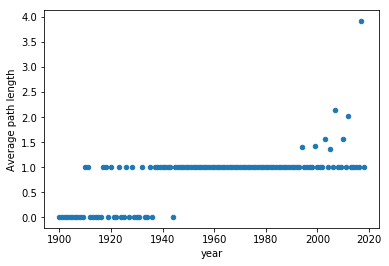

In [52]:
aplDynamicDataFrame.plot(kind="scatter", x="year", y="Average path length")
plt.savefig("averagePathLength.png")
plt.show()